In [1]:
import cantera as ct    # import cantera
import math             # import math (sqrt, exp, etc.)
from scipy.integrate import solve_ivp  # solves ODE (initial value problems)
import scipy.integrate as integrate
import matplotlib.pyplot as plt      # does matlab-like plotting
import numpy as np                    # does a bunch of array stuff

In [2]:
# This piece of code is taken from the following source to give a status bar on the ODE solver. 
# https://towardsdatascience.com/do-stuff-at-each-ode-integration-step-monkey-patching-solve-ivp-359b39d5f2

from scipy.integrate._ivp.rk import OdeSolver  # this is the class we will monkey patch

from tqdm import tqdm

### monkey patching the ode solvers with a progress bar

# save the old methods - we still need them
old_init = OdeSolver.__init__
old_step = OdeSolver.step

# define our own methods
def new_init(self, fun, t0, y0, t_bound, vectorized, support_complex=False):

    # define the progress bar
    self.pbar = tqdm(total=t_bound - t0, unit='ut', initial=t0, ascii=True, desc='IVP')
    self.last_t = t0
    
    # call the old method - we still want to do the old things too!
    old_init(self, fun, t0, y0, t_bound, vectorized, support_complex)


def new_step(self):
    # call the old method
    old_step(self)
    
    # update the bar
    tst = self.t - self.last_t
    self.pbar.update(tst)
    self.last_t = self.t

    # close the bar if the end is reached
    if self.t >= self.t_bound:
        self.pbar.close()


# overwrite the old methods with our customized ones
OdeSolver.__init__ = new_init
OdeSolver.step = new_step

In [3]:
gasAmbient = ct.Solution("gri30_highT_He.cti")

In [4]:
#--------------------------------------------------Ambient Fuel Setup--------------------------------------------------------

fuel = 'CH4:1'         
ox = 'O2:1, N2:3.76'

Tamb = 300 
Pamb = 101325 

gasAmbient.set_equivalence_ratio(0, fuel, ox)
gasAmbient.TP = Tamb, Pamb


In [5]:
#--------------------------------------------------Initial Definitions ------------------------------------------------------
B = 0.082                     #bore
L = 0.14554                   #connecting rod length
S = 0.0904                    #stroke length
Cr = 16.7                     #compression ratio
intake_rise_factor = 20 
intake_open_angle = 0 
intake_close_angle = 220 
exhaust_rise_factor = 20
exhaust_open_angle = 540
exhaust_close_angle = 720
intake_max_area = 0
exhaust_max_area =0

Ap = (np.pi/4)*(B**2)         #piston area                                                                     
Vd = S*Ap                     #displacement volume                                                                     
Vc = Vd/(Cr - 1)              #clearance volume                                                               
R = S/2                       #length of crank arm                                                                          
theta = 0                     #initial theta for area derivation

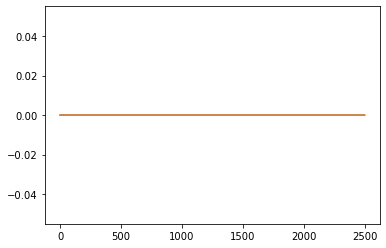

In [6]:
#------------------------------------------------Valve Area Calculation ------------------------------------------------------

def intake_valve_area(theta):                           #code taken from project file
    theta_shift = 360.
    t = (theta + theta_shift) % 720
    to_rel = intake_open_angle + theta_shift
    tc_rel = intake_close_angle + theta_shift
    
    y = intake_max_area*0.5*(
    np.tanh((t - to_rel)/intake_rise_factor) -
    np.tanh((t - tc_rel)/intake_rise_factor))
    return y

def exhaust_valve_area(theta):
    theta_shift = 360.
    t = (theta + theta_shift) % 720
    to_rel = exhaust_open_angle - theta_shift
    tc_rel = exhaust_close_angle - theta_shift
    
    y = exhaust_max_area*0.5*(
    np.tanh((t - to_rel)/exhaust_rise_factor) -
    np.tanh((t - tc_rel)/exhaust_rise_factor))
    return y

angle = np.arange(0, 2500)                                              #graph checks for accuracy
area_in = (intake_valve_area(angle) * 10000).tolist()
area_out = (exhaust_valve_area(angle) * 10000).tolist()
angle = angle.tolist()
plt.plot(angle, area_in, area_out)

In [7]:
def CV_Reactor_RHS(t,y,gas):
    # t = time
    # y = the solution vector: y[0] = temperature, y[1] = density, y[2:nSpecies] = mass fractions
   
    dy = np.zeros(np.size(y))   
    
    T = y[0];          #sets up solution vector
    density = y[1];  
    massFrac = y[2:];  
    
    gas.set_unnormalized_mass_fractions(massFrac)  
    gas.TD=T, density 
    
    #-----------------------------------------------Important Values-------------------------------------------------
    
    tdot = ((2*np.pi)/60)*N                                   #theta dot
    theta = tdot*t 
    
    Ru = 8.314                                                #gas constant
    
    p0_in = gasAmbient.P        #These next values were split between in and out to calculate mdot_in and mdot_out respectively
    pb_in = gas.P
    A_in = intake_valve_area(np.degrees(theta))    
    g_in = gasAmbient.cp / gasAmbient.cv   
    temperature_in = gasAmbient.T        #ambient or current gas values are called for specific values depending on the stroke
    
    p0_out = gas.P
    pb_out = gasAmbient.P
    A_out = (exhaust_valve_area(np.degrees(theta)))
    g_out = gas.cp / gas.cv
    temperature_out = T
    
    hout = gas.enthalpy_mass                                  #enthalpy out
    hin = gasAmbient.enthalpy_mass                            #enthalpy in
    Qdot = 0
    cv_mix = gas.cv_mass
    u_mix = gas.int_energy_mass
    Yi_in = gasAmbient.Y
    mws  = gas.molecular_weights                
    wdot = gas.net_production_rates * mws                     #both converted to mass basis
    ui = gas.partial_molar_int_energies / mws  
    
    # ----------------------------------------Geometrical and Mass Flow Equations--------------------------------------
    
    M_in = np.min([1, np.sqrt(2 * np.max([(p0_in/pb_in)**((g_in-1)/g_in) - 1, 0]) / (g_in - 1))])
    M_out = np.min([1, np.sqrt(2 * np.max([(p0_out/pb_out)**((g_out-1)/g_out) - 1, 0]) / (g_out - 1))])
    
    lamb_in = M_in * np.sqrt(g_in) * (1 + M_in**2 * (g_in - 1) / 2) ** (-(g_in+1)/(g_in-1)/2)
    lamb_out = M_out * np.sqrt(g_out) * (1 + M_out**2 * (g_out - 1) / 2) ** (-(g_out+1)/(g_out-1)/2) 
    
    mf_in = (p0_in*lamb_in) / (np.sqrt(Ru*temperature_in))  
    mf_out = (p0_out*lamb_out) / (np.sqrt(Ru*temperature_out))
    
    mdot_in = A_in*mf_in 
    mdot_out = A_out*mf_out 
    
    mdot = mdot_in - mdot_out
    
    volume = Vc + Ap*(L + R + R*math.cos(theta + np.pi) - np.sqrt(L**2-(R*math.sin(theta + np.pi))**2))  
    
    dV_dt = tdot*Ap*R*math.sin(theta + np.pi)*(-1 + R*math.cos(theta + np.pi)/np.sqrt(L**2-(R*math.sin(theta + np.pi))**2))  
    
    dW_dt = gas.P * dV_dt                       #all equations either generally known or taken from project file
    
    mass = density * volume
                                               
    # -------------------------------------------Governing Equations---------------------------------------------------
    
    dYdt = ((volume/mass)*wdot)-((massFrac/mass)*mdot)+((1/mass)*(mdot_in*Yi_in))-((1/mass)*(mdot_out*massFrac))
    dTdt = (-dW_dt + (hin*mdot_in) - (hout*mdot_out) - (mass*np.sum(ui*dYdt)) - (mdot*u_mix))/(mass*cv_mix)
    drho_dt = ((1/volume) * mdot) - ((density / volume) * dV_dt)
    
   
    dy[0] = dTdt
    dy[1] = drho_dt
    dy[2:] = dYdt
    
    return dy

In [8]:
def integrate_CV_reactor(gas, tEnd,atol=1.e-10, rtol=1.e-8):

    # set the initial conditions for the reactor
    y =  np.zeros(gas.n_species+2) 
    y[0] = gas.T
    y[1] = gas.density_mass     #density solution vector added
    y[2:] = gas.Y

    # solve the ODEs for the reactor.  This is equivalent to ode15s in Matlab.
    soln = integrate.solve_ivp(fun=lambda t, y: CV_Reactor_RHS(t,y,gas), 
                               t_span=[0,tEnd],y0=y,method='BDF',rtol=rtol,atol=atol);
    return soln

In [9]:
def P_heat_release_CV_Reactor(soln, gas):
    # Compute the pressure and rate of heat release based on the solution
    # to a CV reactor
    
    # find the number of time points and pre-allocate an array
    npt = len(soln.t)
    p_hr = np.zeros((2,npt))
    
    # loop over over each time, set the gas composition and compute the pressure.  
    for i in range(npt):
        # set the gas composition.  Note: the y[1:,i] grabs all elements in the array after 1
        gas.TDY = soln.y[0,i], soln.y[1,i], soln.y[2:,i] 
        p = gas.P # compute the pressure
        
        # compute the chemical heat release rate
        hr = -np.sum(gas.net_production_rates*gas.partial_molar_int_energies)
        
        # store the pressure and heat release rate
        p_hr[0,i] = p
        p_hr[1,i] = hr
        
    return p_hr

In [10]:
gas = ct.Solution("gri30_highT_He.cti")

In [11]:
#PART 1 

In [12]:
#2500 RPM  ---  This initial code is to start up the engine for 30 cycles, else graphs will be incorrect

N = 2500              

cycles = 30
cycletime = cycles*(4*np.pi)/(((2*np.pi)/60)*N)    #need to convert cycles into time for integration


gas.TPX = 300, 101325, {'Ar':1}

soln = integrate_CV_reactor(gas, cycletime)

IVP: 100%|#########################################################################| 1.44/1.44 [00:07<00:00,  4.96s/ut]


IVP: 100%|#######################################################################| 0.048/0.048 [00:00<00:00,  5.71s/ut]


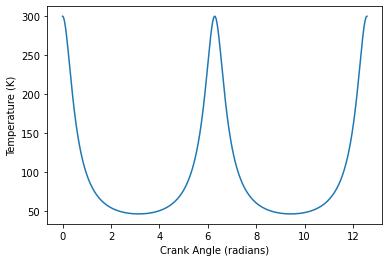

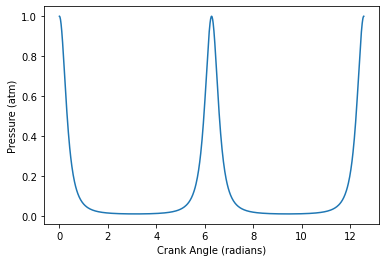

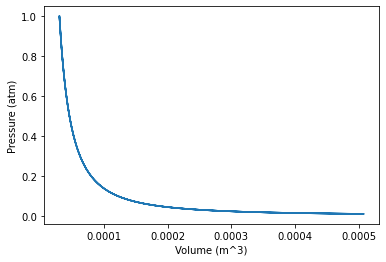

[101334.97062493 101334.97053581 101334.97034366 101334.95934912
 101334.938026   101334.81706404 101334.60460812 101334.29842677
 101333.13604974 101331.39620353 101329.07863632 101308.69841098
 101273.75599328 101224.27593028 101116.16503539 100971.81436401
 100791.47746823 100575.47133565 100131.75947915  99590.0008006
  98952.83522126  98223.32669102  97404.92997627  95261.73549211
  93644.16821997  91877.59467904  89977.92871039  87961.52686975
  85844.90306243  83644.46221096  80961.20125632  78208.89035723
  75411.44070048  72590.9964048   69767.72380754  66959.68304453
  64900.04709303  62863.20755982  60854.22156207  58877.52986458
  56936.98272238  55035.87094429  52789.33873458  50608.68301512
  48496.90072544  46456.1249339   44487.72129768  42313.33702185
  40235.75384158  38254.21288209  36367.24419164  34572.80198969
  32868.38594714  31137.61503307  29503.23230917  27961.17213145
  26507.23059497  25137.1413273   23846.63710138  22770.12620615
  21749.50417826  20781.99

In [15]:
N = 2500      #Single high temp/pressure cycle for 2500 RPM - 31st cycle       

cycles = 1
cycletime = cycles*(4*np.pi)/(((2*np.pi)/60)*N) 

soln = integrate_CV_reactor(gas, cycletime)

dt = ((2*np.pi)/60)*N 


#---------------------------------------------------T vs t Graph-------------------------------------------------------

plot1 = plt.figure(1)
plt.plot(soln.t*dt, soln.y[0,:])            #multiply soln.t by dt to get in terms of crank angle
plt.xlabel('Crank Angle (radians)')
plt.ylabel('Temperature (K)')
plt.show()


#---------------------------------------------------P vs t Graph-------------------------------------------------------

p_hr = P_heat_release_CV_Reactor(soln, gas)
plot2 = plt.figure(2)
plt.plot(soln.t*dt, p_hr[0,:]/101325)
plt.xlabel('Crank Angle (radians)')
plt.ylabel('Pressure (atm)')
plt.show()

plt.show()


#---------------------------------------------------P vs V Graph-------------------------------------------------------


vol = np.zeros(len(soln.t))

for i in range(len(soln.t)):             #function to receive an array of volume values
    theta = dt*soln.t[i]
    vol[i] = Vc + Ap*(L + R + (R*math.cos(theta + np.pi)) - ((L**2)-((R**2)*(math.sin(theta + np.pi))**2))**0.5)    

plot4 = plt.figure(4)
plt.plot(vol, p_hr[0,:]/101325)
plt.xlabel('Volume (m^3)')
plt.ylabel('Pressure (atm)')
plt.show()

print(p_hr[0,:])
